### Try the OpenSoundScape machine learning functionality

- So far we've created an AudioFileDataset which references long recordings on disk, providing 3s clip intervals and target presence or absence for these clips. 
- Normally for opensoundscape model training, they expect a folder full of positive audio and a folder full of negative audio samples, but that's not the format our data is in. We have tagged long recordings which contain both the positive and negative labels. 
- When I tried passing the AudioFileDataset to FastAI and running a training cycle, loading the spectrograms was too slow. 
- This notebook attempts to use OpenSoundScape's methods for training instead. 

In [20]:
# !pip install wandb
# ! pip install wandb --upgrade

In [21]:
%env PYTORCH_ENABLE_MPS_FALLBACK 1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [25]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [39]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor
import torch

In [40]:
# load the raw data
data_path = Path.cwd().parent.parent / "data"
train_df_path = Path.cwd().parent.parent / "data" / "processed" / "train_set"
df_train = pd.read_pickle(train_df_path / "train_set.pkl")

70 not downloaded
downloading 0 clips
skipped 0 previously downloaded files

--------------------------------------------------
before filtering undefined clips
recordings per task method = 
 task_method
1SPT    207551
1SPM     74805
None     44385
Name: count, dtype: int64
total recordings = 326741

Tags generated from each tagging method:
             target_presence  target_absence
task_method                                 
1SPM                  2009.0         13236.0
1SPT                  2483.0         38530.0
NaN                    762.0          3262.0
total target clips =  5254
total absence clips =  55028
total available human labelled target tags = 4204
undefined 266459

--------------------------------------------------
after filtering undefined clips
recordings per task method = 
 task_method
1SPT    41013
1SPM    15245
None     4024
Name: count, dtype: int64
total recordings = 60282

Tags generated from each tagging method:
             target_presence  target_absence
ta

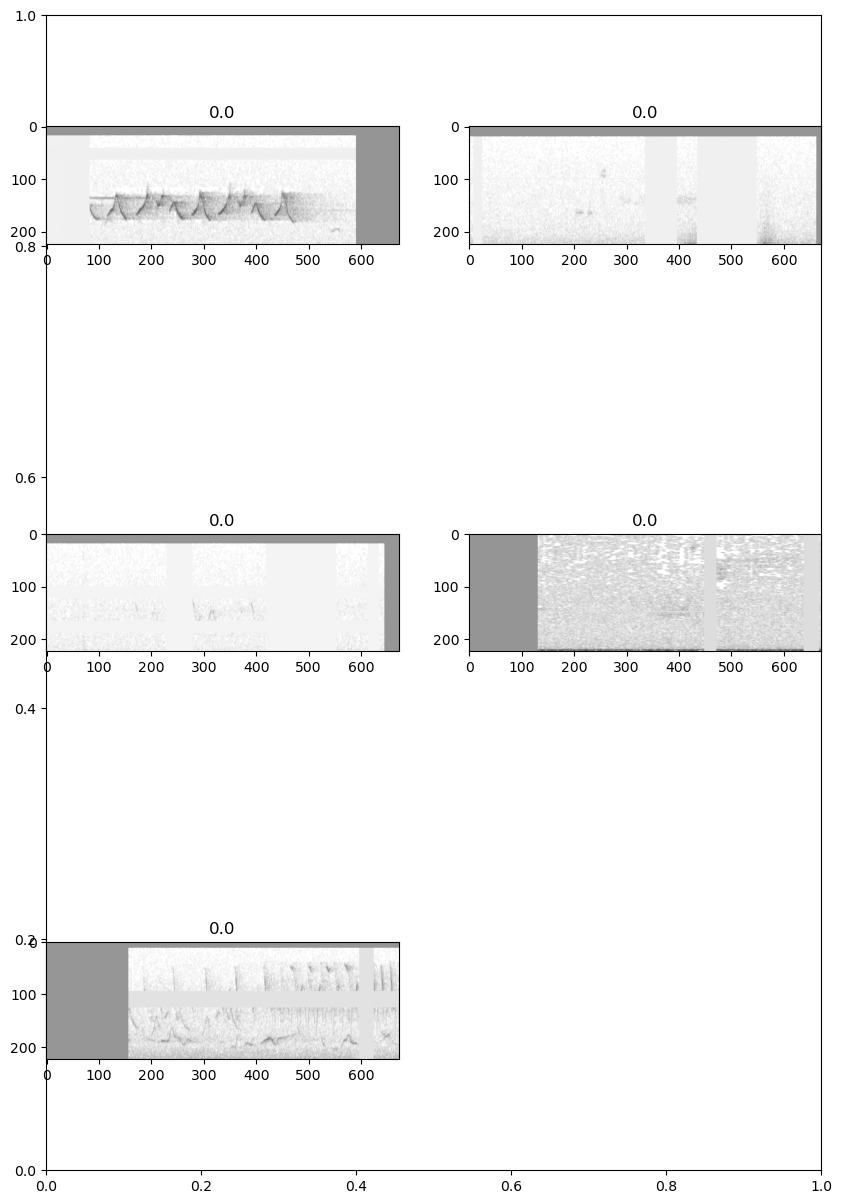

In [44]:
train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(df_train, target_species = "OSFL", download_n=0)

In [46]:
train_df = train_dataset.label_df
valid_df = valid_dataset.label_df


In [49]:
train_df.target_presence.value_counts(), valid_df.target_presence.value_counts()

(target_presence
 0.0    44667
 1.0     4236
 Name: count, dtype: int64,
 target_presence
 0.0    10361
 1.0     1018
 Name: count, dtype: int64)

In [32]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) or downsample so that all classes have 800 samples
balanced_train_df = resample(train_df,n_samples_per_class=800,random_state=0)

In [36]:
balanced_train_df.target_presence.value_counts()

target_presence
1    800
Name: count, dtype: int64

In [37]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet34 architecture
architecture = 'resnet18'

# Can use this code to get your classes, if needed
class_list = list(train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
)


In [30]:
print(f'model.device is: {model.device}')

model.device is: mps


In [31]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='osfl',
    config={
    "epochs":2,
    "log_histograms":False,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [32]:
model.train(
    balanced_train_df,
    valid_df,
    epochs = 2,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/13 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),


Epoch: 0 [batch 0/13, 0.00%] 
	DistLoss: 1.022
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (

Epoch: 0 [batch 10/13, 76.92%] 
	DistLoss: 0.106
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),


Metrics:
	MAP: 1.000

Validation.


  0%|          | 0/191 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (

Metrics:
	MAP: 0.119

Training Epoch 1


  0%|          | 0/13 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),


Epoch: 1 [batch 0/13, 0.00%] 
	DistLoss: 0.000
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (

Epoch: 1 [batch 10/13, 76.92%] 
	DistLoss: 0.000
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),


Metrics:
	MAP: 1.000

Validation.


  0%|          | 0/191 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (

Metrics:
	MAP: 0.102

Best Model Appears at Epoch 0 with Validation score 0.119.


In [33]:

model.train(
    balanced_train_df,
    valid_df,
    epochs = 2,
    batch_size = 64,
    log_interval = 100, #log progress every 100 batches
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    save_interval = 10, #save checkpoint every 10 epochs
)


Training Epoch 2


  0%|          | 0/13 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),


Epoch: 2 [batch 0/13, 0.00%] 
	DistLoss: 0.000
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (

Metrics:
	MAP: 1.000

Validation.


  0%|          | 0/191 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (

Metrics:
	MAP: 0.098

Training Epoch 3


  0%|          | 0/13 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),


Epoch: 3 [batch 0/13, 0.00%] 
	DistLoss: 0.000
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (

Metrics:
	MAP: 1.000

Validation.


  0%|          | 0/191 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Tensor([s.labels for s in samples]),
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/sample.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (

Metrics:
	MAP: 0.092

Best Model Appears at Epoch 2 with Validation score 0.098.


The resnet34 took 3m30 and didn't converge. The resnet18 took 2m 41 and didn't converge. 
The similarity in training time between different sized architectures suggests that most of the time is spent making spectrograms on the fly.

Looking at the plots on Weights and Biases, I can see that the model is overfitting to the specifics of the training set without any improvement on the validation set during training. 

For some reason validation_loss isn't plotted by weights and biases. Look for a way of plotting this

Next steps:

Try to train a model using precomputed spectrograms:

1. Get all of the recordings from the training dataset downloaded (Only using half of them at this stage).
2. Try using the opensoundscape resample loss.
3. Precompute spectrograms from the downloaded audio and save them into 2 folders. Choose a sample from the no_call sections
4. Use these as training, validation and test data to train a model using the fastai framework. 

In [34]:
model.loss_hist

{0: 0.08968666, 1: 0.0, 2: 1.9862881e-10, 3: 0.0}

In [35]:
train_dataset.class_counts()
valid_dataset.class_counts()

(Index(['target_presence', 'target_absence'], dtype='object'),
 array([ 1072., 11120.]))

In [36]:
model.network.fc

Linear(in_features=512, out_features=1, bias=True)